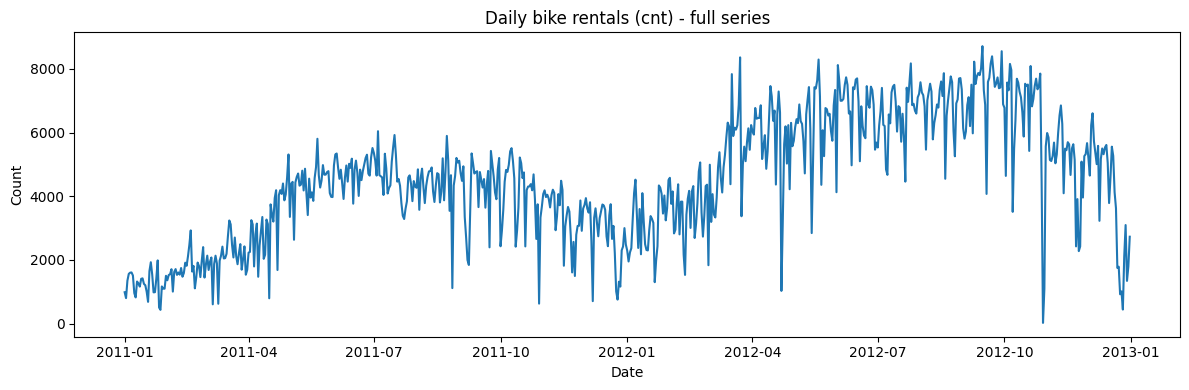

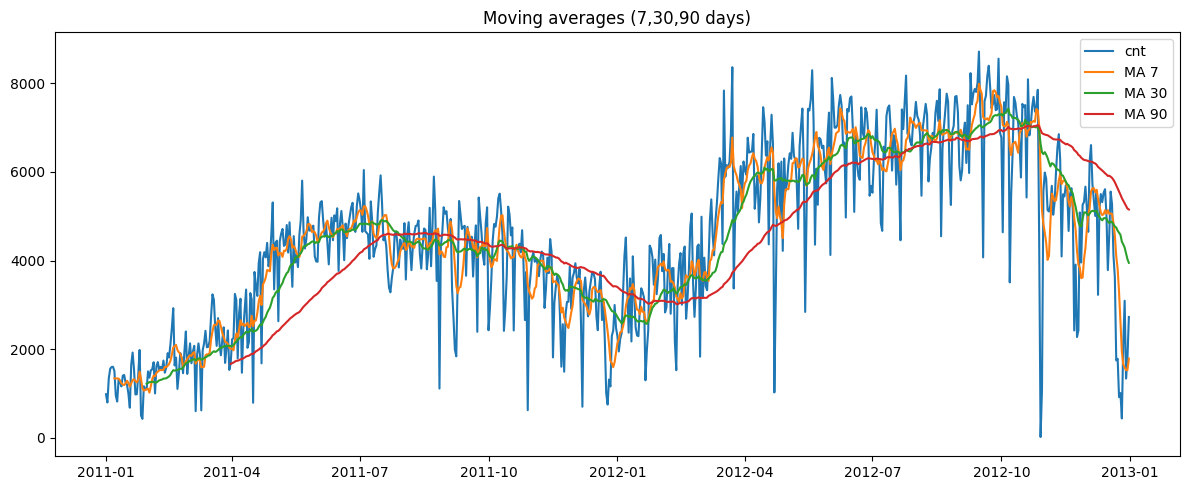

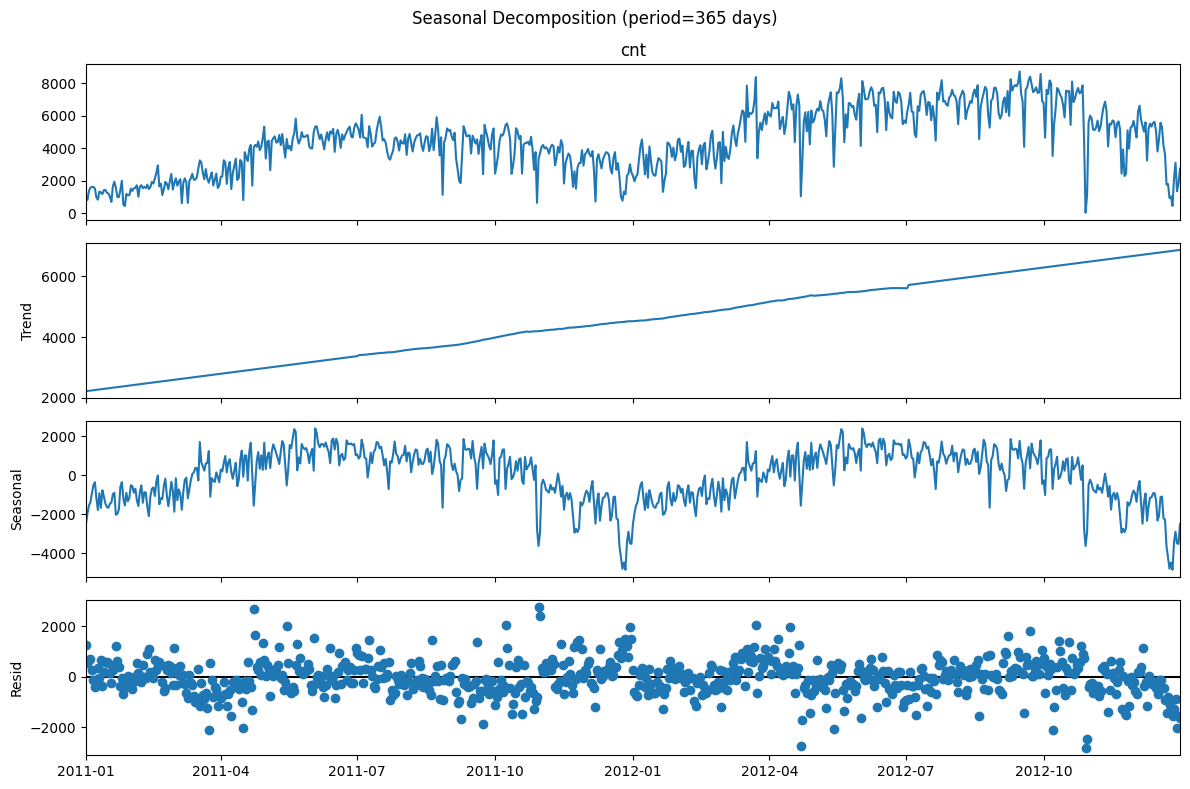

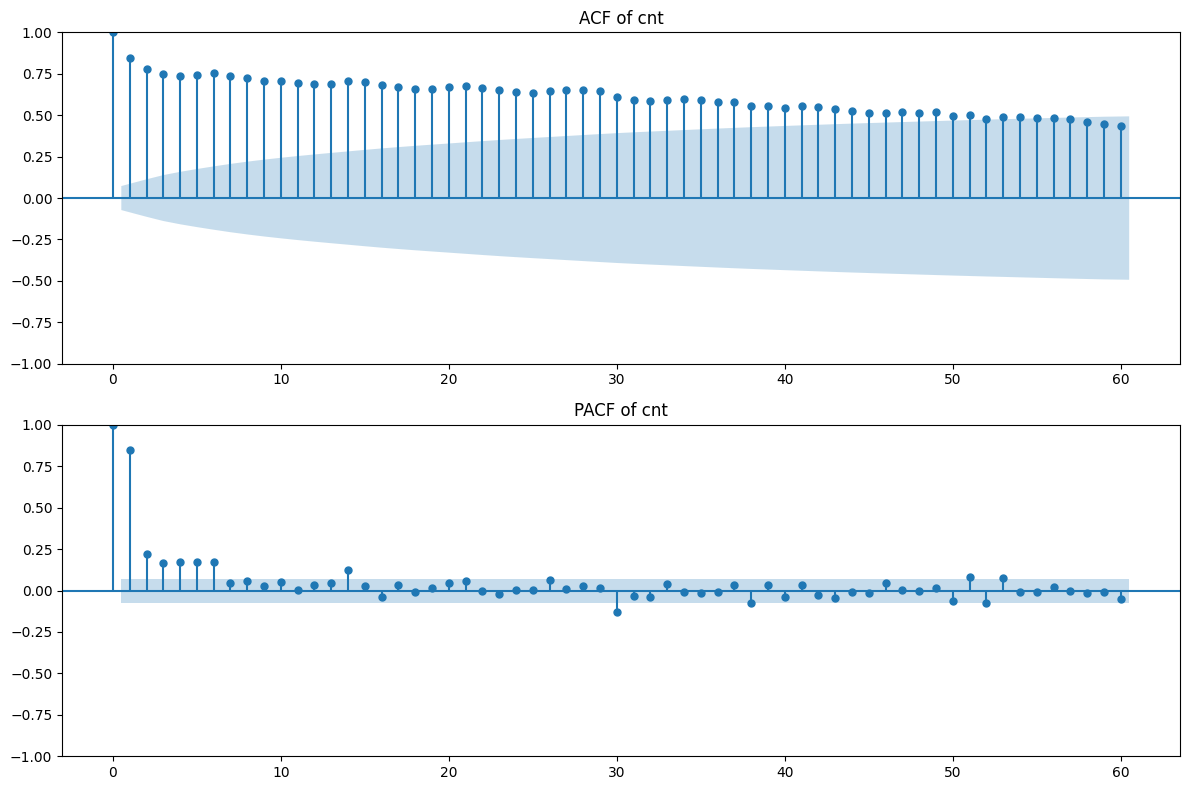

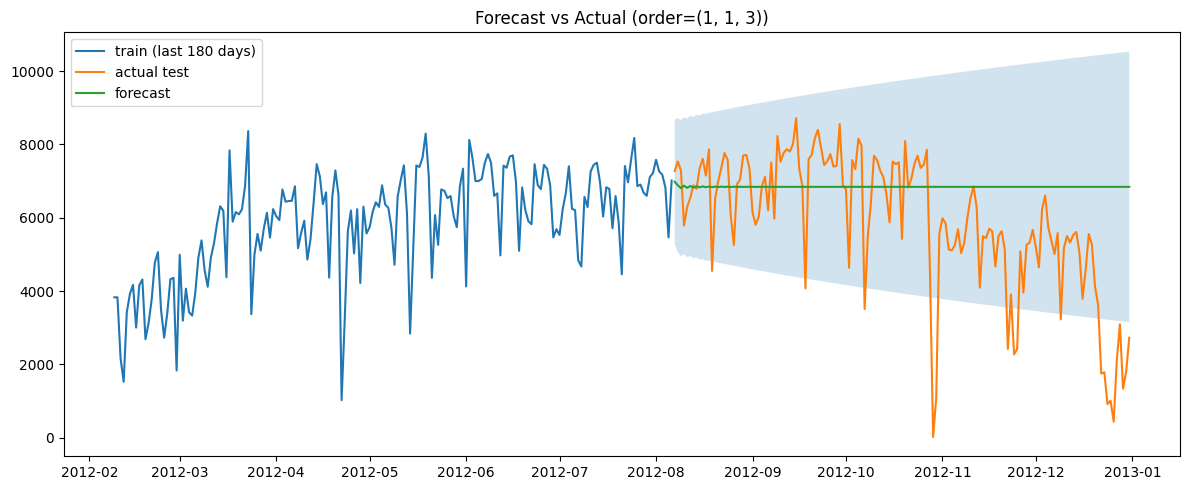

Basic dataset info:


,key,value
0,start,2011-01-01 00:00:00
1,end,2012-12-31 00:00:00
2,n_records,731
3,freq,daily (user confirmed)
4,timezone,America/Sao_Paulo



ADF test summary:


,metric,value
0,adf_stat,-1.877448
1,pvalue,0.342743
2,used_lag,13.000000
3,nobs,717.000000



Top 10 ARIMA (p,d,q) by AIC on training set:


,p,d,q,aic
0,1,1,3,9459.112023
1,0,1,3,9459.720536
2,3,1,3,9460.219625
3,2,1,3,9460.956531
4,2,2,3,9471.957055
5,3,2,3,9472.021632
6,0,1,2,9474.080946
7,1,1,2,9475.193984
8,2,0,3,9475.249271
9,3,1,1,9475.343188



Selected best order by AIC on train: (1, 1, 3) (AIC=9459.11)

Forecast evaluation on the entire test set:


,metric,value
0,RMSE,2098.720879
1,MAE,1517.739649
2,MAPE%,266.850928



Horizon evaluation (walk-forward RMSE) for horizons tested:


,horizon_days,RMSE
0,7,1571.892653
1,14,1643.711672
2,30,1909.199688
3,60,2695.803766


Chosen best horizon (lowest RMSE): 7.0 days (RMSE=1571.89)

HyperLogLog (simulated) estimates per 30-day window (weathersit distinct counts):


,window_start,hll_estimate
0,2011-01-01,3
1,2011-01-31,2
2,2011-03-02,3
3,2011-04-01,3
4,2011-05-01,2
5,2011-05-31,2
6,2011-06-30,2
7,2011-07-30,2
8,2011-08-29,3
9,2011-09-28,3



Count-Min Sketch estimated counts vs exact counts (by cnt bucket):


,bucket,estimate_count,exact_count
0,0-199,1,1
1,200-399,0,0
2,400-599,3,3
3,600-799,7,7
4,800-999,7,7
5,1000-1199,13,13
6,1200-1399,9,9
7,1400-1599,20,20
8,1600-1799,18,18
9,1800-1999,20,20


In [2]:
# Python code to run the time series analysis and Redis-probabilistic demonstrations.
# This will be executed and outputs (plots, dataframes) shown to the user.
# It uses the uploaded file /mnt/data/day.csv and Readme.txt already present.
# Follow-up: The notebook/code produced can be copied to a .ipynb for the user's repo.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("/mnt/data/day.csv")
df['dteday'] = pd.to_datetime(df['dteday'], format="%Y-%m-%d")
df = df.set_index('dteday').sort_index()
try:
    df.index = df.index.tz_localize('America/Sao_Paulo')
except Exception:
    try:
        df.index = df.index.tz_convert('America/Sao_Paulo')
    except Exception:
        pass

y = df['cnt'].astype(float)

info = {
    "start": str(y.index[0]),
    "end": str(y.index[-1]),
    "n_records": len(y),
    "freq": "daily (user confirmed)",
    "timezone": "America/Sao_Paulo"
}
info_df = pd.DataFrame(list(info.items()), columns=["key","value"])

plt.figure(figsize=(12,4))
plt.plot(y)
plt.title("Daily bike rentals (cnt) - full series")
plt.xlabel("Date")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(y, label='cnt')
plt.plot(y.rolling(7).mean(), label='MA 7')
plt.plot(y.rolling(30).mean(), label='MA 30')
plt.plot(y.rolling(90).mean(), label='MA 90')
plt.legend()
plt.title("Moving averages (7,30,90 days)")
plt.tight_layout()
plt.show()

decomp = seasonal_decompose(y, period=365, model='additive', extrapolate_trend='freq')
fig = decomp.plot()
fig.set_size_inches(12,8)
plt.suptitle("Seasonal Decomposition (period=365 days)")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(y, ax=ax[0], lags=60)
plot_pacf(y, ax=ax[1], lags=60, method='ywm')
ax[0].set_title("ACF of cnt")
ax[1].set_title("PACF of cnt")
plt.tight_layout()
plt.show()

from statsmodels.tsa.stattools import adfuller
adf_res = adfuller(y.dropna())
adf_summary = {
    'adf_stat': adf_res[0],
    'pvalue': adf_res[1],
    'used_lag': adf_res[2],
    'nobs': adf_res[3],
}
adf_summary_df = pd.DataFrame(list(adf_summary.items()), columns=['metric','value'])

n = len(y)
train_size = int(0.8 * n)
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

p_range = range(0,4)
d_range = range(0,3)
q_range = range(0,4)

best_aic = np.inf
best_order = None
results = []

for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                mod = SARIMAX(y_train, order=(p,d,q), enforce_stationarity=False, enforce_invertibility=False)
                res = mod.fit(disp=False)
                results.append((p,d,q,res.aic))
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_order = (p,d,q)
            except Exception as e:
                continue

results_df = pd.DataFrame(results, columns=['p','d','q','aic']).sort_values('aic').reset_index(drop=True)

best_order, best_aic, results_df.head(10)

model = SARIMAX(y_train, order=best_order, enforce_stationarity=False, enforce_invertibility=False)
model_res = model.fit(disp=False)

forecast = model_res.get_forecast(steps=len(y_test))
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

rmse_full = math.sqrt(mean_squared_error(y_test, pred))
mae_full = mean_absolute_error(y_test, pred)
mape_full = (np.abs((y_test - pred) / y_test)).replace([np.inf, -np.inf], np.nan).dropna().mean() * 100

metrics_df = pd.DataFrame({
    'metric': ['RMSE','MAE','MAPE%'],
    'value': [rmse_full, mae_full, mape_full]
})

plt.figure(figsize=(12,5))
plt.plot(y_train[-180:], label='train (last 180 days)')
plt.plot(y_test, label='actual test')
plt.plot(pred, label='forecast')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)
plt.legend()
plt.title(f"Forecast vs Actual (order={best_order})")
plt.tight_layout()
plt.show()

from tqdm import tqdm

def walk_forward_rmse(series, order, horizon):
    errors = []
    n = len(series)
    for origin in range(train_size, n - horizon + 1):
        train_slice = series.iloc[:origin]
        try:
            mod = SARIMAX(train_slice, order=order, enforce_stationarity=False, enforce_invertibility=False)
            res = mod.fit(disp=False)
            fc = res.get_forecast(steps=horizon).predicted_mean
            pred_val = fc.iloc[-1]
            actual_val = series.iloc[origin + horizon - 1]
            errors.append((actual_val - pred_val)**2)
        except Exception:
            continue
    if len(errors)==0:
        return np.nan
    return math.sqrt(np.mean(errors))

horizons = [7,14,30,60]
horizon_results = []
for h in horizons:
    rmse_h = walk_forward_rmse(y, best_order, h)
    horizon_results.append((h, rmse_h))

horizon_df = pd.DataFrame(horizon_results, columns=['horizon_days','RMSE']).sort_values('RMSE')

best_horizon_row = horizon_df.iloc[0]

try:
    import fakeredis
    r = fakeredis.FakeStrictRedis()
    redis_available = True
except Exception:
    r = None
    redis_available = False

from collections import defaultdict
hll_estimates = []
window =
for start in range(0, len(df)-window+1, window):
    chunk = df.iloc[start:start+window]
    key = f"hll:window:{start}"
    elements = [str(x) for x in chunk['weathersit'].values]
    if redis_available:
        r.delete(key)
        for e in elements:
            r.pfadd(key, e)
        est = r.pfcount(key)
    else:
        # fallback: use exact distinct count (we'll show this but explain difference)
        est = len(set(elements))
    hll_estimates.append({'window_start':chunk.index[0].strftime('%Y-%m-%d'),'hll_estimate':est})

hll_df = pd.DataFrame(hll_estimates)

class CountMinSketch:
    def __init__(self, width=200, depth=5, seed=42):
        self.width = width
        self.depth = depth
        self.tables = np.zeros((depth, width), dtype=int)
        import random
        self.random = random.Random(seed)
        self.salts = [self.random.randint(0,2**32-1) for _ in range(depth)]
    def _hash(self, x, i):
        return (hash(str(x) + str(self.salts[i])) % self.width)
    def add(self, x, count=1):
        for i in range(self.depth):
            idx = self._hash(x, i)
            self.tables[i, idx] += count
    def estimate(self, x):
        vals = []
        for i in range(self.depth):
            idx = self._hash(x, i)
            vals.append(self.tables[i, idx])
        return min(vals)

bins = list(range(0, 2001, 200))
labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
buckets = pd.cut(df['cnt'], bins=bins, labels=labels, right=False)
cms = CountMinSketch(width=300, depth=7)
for b in buckets:
    cms.add(b)

cms_list = []
for lab in labels:
    est = cms.estimate(lab)
    cms_list.append({'bucket':lab,'estimate_count':int(est)})
cms_df = pd.DataFrame(cms_list)

exact_counts = buckets.value_counts().sort_index().reset_index()
exact_counts.columns = ['bucket','exact_count']

cms_comp = pd.merge(cms_df, exact_counts, on='bucket', how='left')

output = {
    "basic_info": info_df,
    "adf_summary": adf_summary_df,
    "aic_rankings_top10": results_df.head(10),
    "best_order": best_order,
    "best_order_aic": best_aic,
    "forecast_metrics": metrics_df,
    "horizon_results": horizon_df,
    "best_horizon": best_horizon_row,
    "hll_summary": hll_df,
    "cms_comparison": cms_comp
}

# Display key tables
print("Basic dataset info:")
display(info_df)
print("\nADF test summary:")
display(adf_summary_df)
print("\nTop 10 ARIMA (p,d,q) by AIC on training set:")
display(results_df.head(10))
print(f"\nSelected best order by AIC on train: {best_order} (AIC={best_aic:.2f})")

print("\nForecast evaluation on the entire test set:")
display(metrics_df)

print("\nHorizon evaluation (walk-forward RMSE) for horizons tested:")
display(horizon_df)
print(f"Chosen best horizon (lowest RMSE): {best_horizon_row['horizon_days']} days (RMSE={best_horizon_row['RMSE']:.2f})")

print("\nHyperLogLog (simulated) estimates per 30-day window (weathersit distinct counts):")
display(hll_df)

print("\nCount-Min Sketch estimated counts vs exact counts (by cnt bucket):")
display(cms_comp)



